In [1]:
import pandas as pd  
import numpy as np
import sys,glob,os,time
import vaex
import math
import scipy


from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sea 



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'},color_codes=False)
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pi = math.pi

[Definition from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_process)

> In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

> Gaussian processes are useful in statistical modelling, benefiting from properties inherited from the normal distribution. For example, if a random process is modelled as a Gaussian process, the distributions of various derived quantities can be obtained explicitly. Such quantities include the average value of the process over a range of times and the error in estimating the average using sample values at a small set of times. While exact models often scale poorly as the amount of data increases, multiple approximation methods have been developed which often retain good accuracy while drastically reducing computation time.

> ### Definition
> A time continuous stochasitc process ${X_t;\in T}$ is Gaussian \emph{if and only if} for every finite set of indices $t_1,\dots,t_k$ in the index set $T$

$$
\begin{equation}
    {\bf X}_{t_1,\dots,t_k} = (X_{t_1},\dots,X_{t_k})
\end{equation}
$$

> is a multivariate Gaussian random variable. That is the same as saying every linear combination of $(X_{t_1},\dots,X_{t_k})$ has a univariate normal (or Gaussian) distribution.

In [2]:
rng = np.random.RandomState(33)

In [3]:
t = np.linspace(0,10,100)

In [4]:
def X_t(t):
    """
    Example of a stationary Gaussian random process
    """
    rng = np.random.RandomState(33)
    xi_1, xi_2 = rng.normal(size=(2,100))
    a = 1
    return xi_1 * np.cos(a*t) + xi_2 * np.sin(a*t)



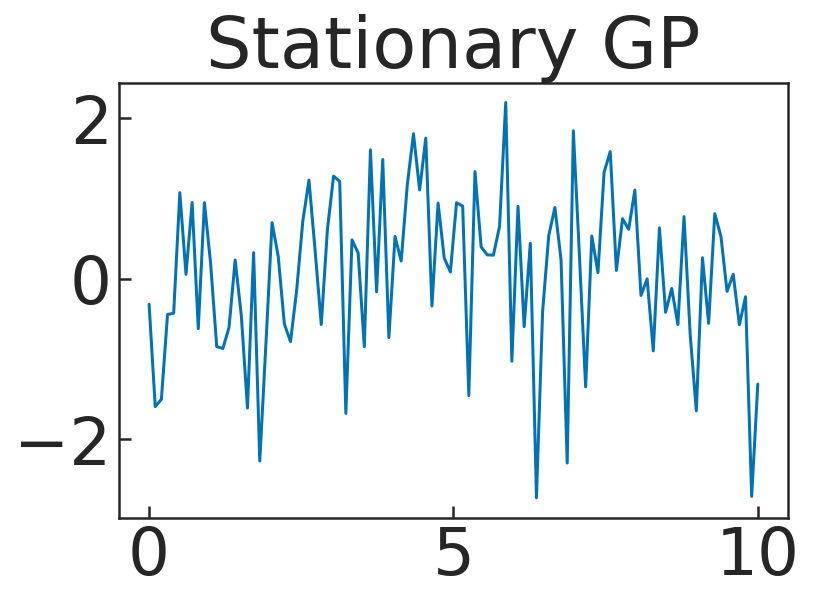

In [5]:
plt.title('Stationary GP')
plt.plot(t, X_t(t))

> A key fact of Gaussian processes is that they can be completely defined by their second-order statistics.

Bailey:
> Recall that in the simple linear regression setting, we have a dependent variable $y$ that we assume can be modeled as a function of an independent variable $x$, i.e. $ y = f(x)+\epsilon $ (where $\epsilon$ is the irreducible error) but we assume further that the function $f$ defines a linear relationship and so we are trying to find the parameters $θ_0$ and $θ_1$ which define the intercept and slope of the line respectively, i.e. 
$ y = \theta_0 + \theta_1 x + \epsilon$. Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. 

> The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible **functions** $f(x)$ that are consistent with the observed data. As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

>Here’s how Kevin Murphy explains it in the excellent textbook Machine Learning: A Probabilistic Perspective:

>>A GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data. Although it might seem difficult to represent a distrubtion over a function, it turns out that we only need to be able to define a distribution over the function’s values at a finite, but arbitrary, set of points, say 
$x_1,\dots,x_N$. A GP assumes that $p(f(x_1),\dots,f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\Sigma_{ij} = k(x_i,x_j)$, where $k$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.

> I’m well aware that things may be getting hard to follow at this point, so it’s worth reiterating what we’re actually trying to do here. There are some points $x$ for which we have observed the outcome $f(x)$ (denoted above as simply $f$). There are some points $x_\ast$ for which we would like to estimate $f(x_\ast)$ (denoted above as $f_\ast$). So we are trying to get the probability distribution $p(f_\ast|f)$ and we are assuming that $f$ and $f_\ast$ together are jointly Gaussian as defined above.

> $\mathcal{N}(\mu, \sigma^2) = \mu + \sigma \mathcal{N}(0,1)$  
> $f_\ast \sim \mu + B \mathcal{N}(0,I)$, where $BB^{T} = \Sigma_\ast$

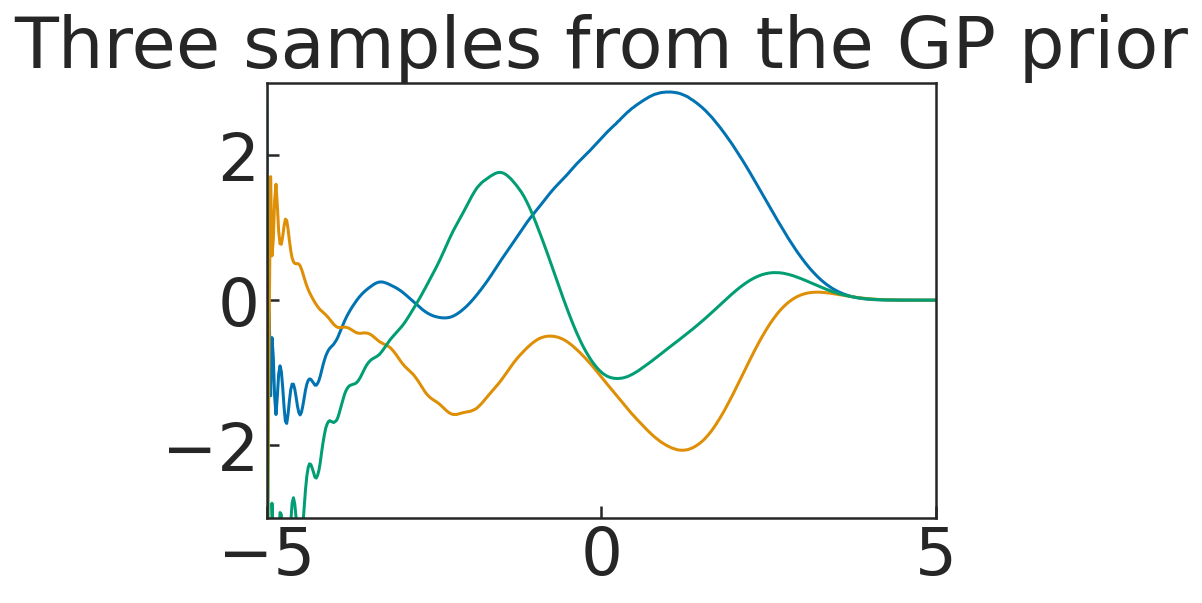

In [6]:
### Example from Katherine Bailey (modified)

# Test data
n = 500
Xtest = np.linspace(-5, 5, n).reshape(-1,1)
rng = np.random.RandomState(7)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = scipy.linalg.cholesky(K_ss + 1e-12*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, rng.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

> Now we’ll observe some data. The actual function generating the $y$ values from our $x$ values, unbeknownst to our model, is the $\sin$ function. We generate the output at our $5$ training points, do the equivalent of the above-mentioned $4$ pages of matrix algebra in a few lines of python code, sample from the posterior and plot it.

Some relevant equations, derived from the conditional probabilities of multi-variate Gaussians  
$\Large
\begin{align}
p(f_s|X_s,X,f) &= \mathcal{N}(f_s|\mu_s,\Sigma_S) \\
\mu_s &= \mu(X_s) + K_S^T K^{-1}(f-\mu(X)) \\
\Sigma_s &= K_{ss} - K_s^T K^{-1} K_s
\end{align}
$  

where $\mu_s$ should be read as $\mu$ of $X_s$ given $X$, such that both $X$ and $X_s$ have means $\mu$ and $\mu_s$.

In this context, we assume there is a data set $D = \{(X,f)\} = \{(x_1, f_1),\dots,(x_N, f_N)\}$ and some unobserved data set that we are interested in $D_s = \{(X_s,f_s)\}$.

To simplify things and omit the usage of `np.linalg.inv` and rather make use of `np.linalg.solve`, let us define a matrix $L_k$ such that  
$\Large
\begin{align}
    L L_k = K_s \\
    L_k^T L_k = K_s^T K^{-1} K_s \\
    L_k^T L^{-1} f = K_s^T K^{-1}f
\end{align}
$  



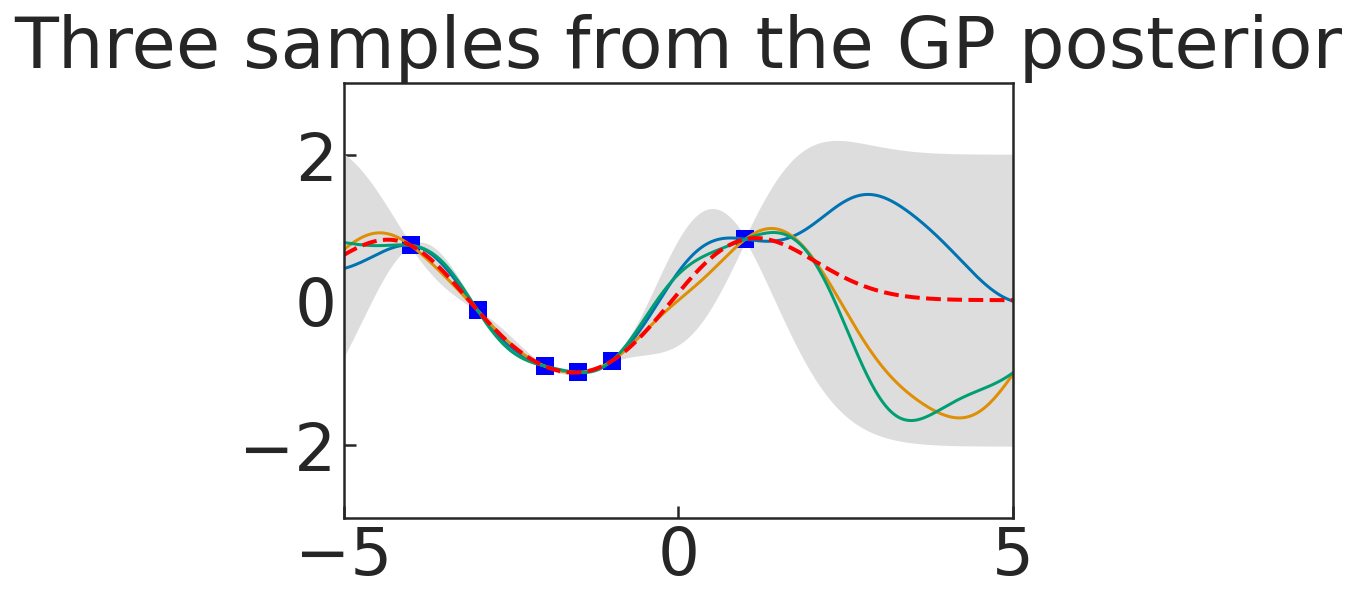

In [7]:
### Based on Katherine Bailey's code (modified)
# For a version with np.linalg.inv see below.

# Setting random state
rng = np.random.RandomState(41)

# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1.5, -1, 1]).reshape(-1,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 1e-10*np.eye(len(Xtrain)))  # the small offset is added to make the algorithm converge


# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
iL_dot_f = np.linalg.solve(L, ytrain)

mu = np.einsum('ij,ik->j', Lk, iL_dot_f)

# Compute the standard deviation so we can plot it
S_s = K_ss - np.einsum('ij,ik->jk',Lk,Lk)
stdv = np.sqrt(S_s.diagonal())

# Sampling three curves given the posterior
L = np.linalg.cholesky(S_s + 1e-12*np.eye(n))
f_post = mu.reshape(-1,1) + np.dot(L, rng.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

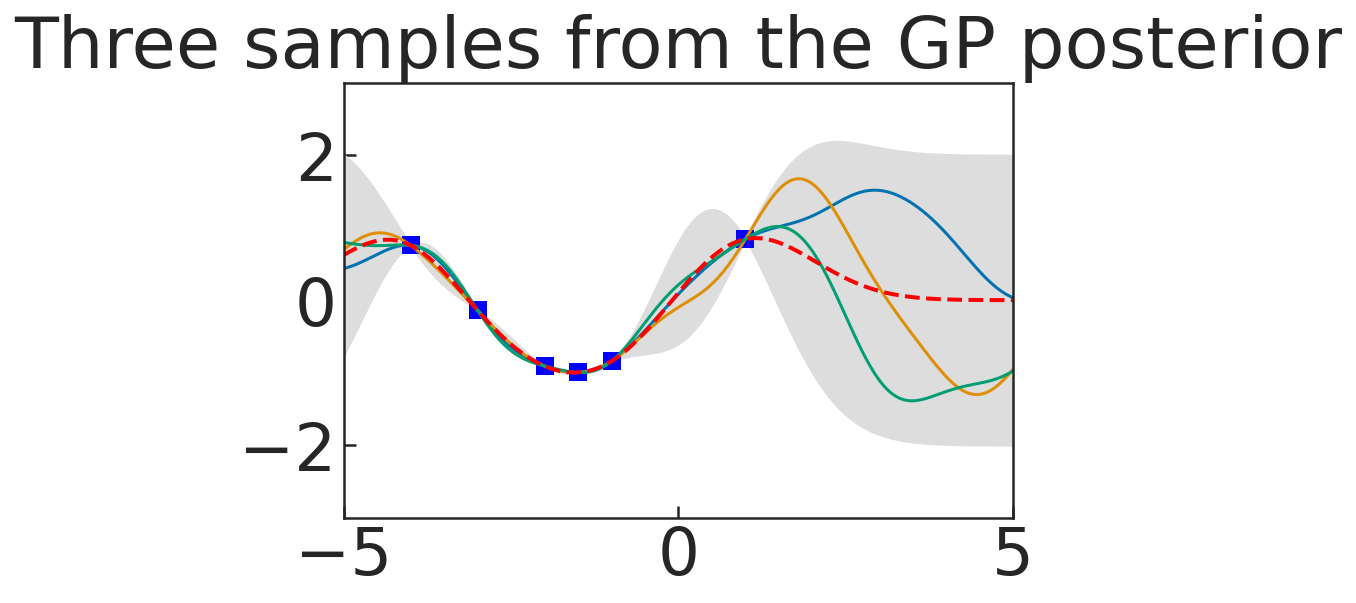

In [8]:
### Version with np.linalg.inv in stead of np.linalg.solve
# Best practice is to use the version above!!!
# Based on Katherine Bailey's code (modified)

# Setting random state
rng = np.random.RandomState(41)

# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1.5, -1, 1]).reshape(-1,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 1e-10*np.eye(len(Xtrain)))  # the small offset is added to make the algorithm converge

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
iK = np.linalg.inv(K)
mu = np.einsum('ij,ik,kn->j', K_s, iK, ytrain)

# Compute the standard deviation so we can plot it
S_s = K_ss - np.einsum('ij,ik,kl',K_s,iK,K_s)
stdv = np.sqrt(S_s.diagonal())

# Sampling three curves given the posterior
L = np.linalg.cholesky(S_s + 1e-12*np.eye(n))
f_post = mu.reshape(-1,1) + np.dot(L, rng.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

The small variations comes from a small floating point error between the two S_s matrices of the order of 1e-10 which results in a larger difference inthe cholesky decompositions for the final L matrices.

One can use cross-validation to determine the best smoothing length (`param` in kernel function)

References:
* https://katbailey.github.io/post/gaussian-processes-for-dummies/
* https://peterroelants.github.io/posts/gaussian-process-tutorial/
* https://en.wikipedia.org/wiki/Gaussian_process
* Lecture by Nando de Freitas [see youtube](https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=8)